# Python Learn by Doing: ENSO, Your Turn! Option 1 Answer Key

**Developed By:** Dr. Kerrie Geil, Mississippi State University

**Original Development Date:** June 2024

**Package Requirements:** xarray, netcdf4, numpy, pandas, scipy, matplotlib, jupyter, geopandas

**Links:** **[OSF project link](https://osf.io/zhpd5/)**, [link to this notebook on github]()

---
**Assignment:**

Using a shapefile with country boundaries, show a table of which South American countries experience statistically significant anomalous temperature and precipitation over at least 50% of the country's area during strong El Nino and La Nina events.

&emsp;Hints:
- Use World_Countries_Generalized.shp for country boundaries and subset to South America
- Repeat the appropriate steps from science questions 1 and 3
- Use the country boundaries on your gridded results to quantify which countries experience anomalous T and PR at the 50% area threshold
- Format your results in a pandas dataframe. Sort the dataframe descending by percent area impacted by anomalous conditions.

# Import packages and define workspace

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats as ss
import geopandas as gpd
import warnings
import os
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

import shapely
import xagg as xa
# from cdo import *
# cdo   = Cdo()  

In [2]:
# create a folder for data downloads
if not os.path.exists('../data/World_Countries'):
    os.makedirs('../data/World_Countries')

In [3]:
# filenames to save data to and download urls
base_filename='../data/World_Countries/World_Countries'

shpfile_info=  {'.cpg':'https://osf.io/5xrgc/download',
                '.dbf':'https://osf.io/3a6rp/download',
                '.prj':'https://osf.io/43mnp/download',
                '.shp':'https://osf.io/r4dez/download',
                '.shp.xml':'https://osf.io/s4cvy/download',
                '.shx':'https://osf.io/kp6cm/download'}

# files we've already downloaded
nino_f = '../data/nino34_anomalies_monthly_NOAA.txt'
t_f = '../data/tavg_monthly_BerkeleyEarth.nc'
pr_f = '../data/precip_monthly_PRECL_NOAA.nc'

# Obtaining the data

We'll use a shapefile of country boundaries called [World Countries, originally obtained from ESRI ArcGIS Hub](https://hub.arcgis.com/datasets/esri::world-countries/explore) in June 2024 and copied to the [enso component of the MSU_py_training OSF project](https://osf.io/e726y/). 

<br>
<font color="green"><b>
**NOTE: You only need to run the following urlretrieve cell once. The data files will then be located on your computer. Files total approximately 130MB in size.**
</b></font> 

In [ ]:
# download shapefile

for ext,url in shpfile_info.items():
    filename=base_filename+ext
    print('downloading',filename)
    urlretrieve(url,filename) # download and save data

# Data Cleaning

We'll copy over the data cleaning steps from the enso_analysis.ipynb as well as subset global country boundaries to South American countries 

In [4]:
# data cleaning copied from enso_analysis.ipynb

year_start = '1948'
year_end = '2023'
base_start = '1981'
base_end = '2010'

dates=pd.date_range('1870-01-01','2024-12-01',freq='MS')

In [5]:
# data cleaning copied from enso_analysis.ipynb

# Nino 3.4 data
nino_raw=pd.read_csv(nino_f,sep=r'\s+',skiprows=1,skipfooter=7,header=None,index_col=0,na_values=-99.99,engine='python')
nino=nino_raw.to_numpy().flatten() 
nino=xr.DataArray(nino,name='nino',dims='time',coords={'time':dates}) 
nino.attrs['standard_name']='nino3.4 index'
nino.attrs['units']='C'
nino=nino.sel(time=slice(year_start,year_end))

# precipitation data
ds=xr.open_dataset(pr_f)
pr=ds.precip
pr=pr.sel(time=slice(year_start,year_end)) 
pr=pr.reindex(lat=pr.lat[::-1]) 
pr.coords['lon']=xr.where(pr.coords['lon']>180,pr.coords['lon']-360,pr.coords['lon'])
roll_len=len(pr.lon)//2
pr=pr.roll(lon=roll_len,roll_coords=True)
pr_base=pr.sel(time=slice(base_start,base_end)) 
pr_clim=pr_base.groupby(pr_base.time.dt.month).mean('time') 
pr_anom=pr.groupby(pr.time.dt.month) - pr_clim  
pr_anom.attrs['standard_name']='pr anomaly'
pr_anom.attrs['units']='mm/day'

# temperature data
ds=xr.open_dataset(t_f)
dates=pd.date_range('1750-01-01','2024-03-01',freq='MS')
ds['time']=dates
ds=ds.rename({'month_number':'month','latitude':'lat','longitude':'lon'})
t_anom_5180=ds.temperature
clim_5180=ds.climatology
t=t_anom_5180.groupby(t_anom_5180.time.dt.month)+clim_5180
t_base=t.sel(time=slice(base_start,base_end))  # subset in time
clim_8110 = t_base.groupby(t_base.time.dt.month).mean('time')  # long term means for each month
t_anom=t.groupby(t.time.dt.month)-clim_8110
t_anom=t_anom.sel(time=slice(year_start,year_end))
t_anom=t_anom.rename('tavg')
t_anom.attrs['standard_name']='T anomaly'
t_anom.attrs['units']='C'

# check first and last time is the same for all data
variables=[nino, pr_anom, t_anom] # list of arrays
for var in variables:
    print(var.name, var.time[0].data,var.time[-1].data)

# clean up
del ds, nino_raw, pr, pr_base, pr_clim,  t, t_anom_5180, t_base

nino 1948-01-01T00:00:00.000000000 2023-12-01T00:00:00.000000000
precip 1948-01-01T00:00:00.000000000 2023-12-01T00:00:00.000000000
tavg 1948-01-01T00:00:00.000000000 2023-12-01T00:00:00.000000000


In [6]:
# load shapefile of global country boundaries
countries=gpd.read_file(base_filename+'.shp')
countries

,COUNTRY,ISO_CC,CONTINENT,LAND_TYPE,LAND_RANK,COUNTRYAFF,geometry
0,Afghanistan,AFG,Asia,Primary land,5,Afghanistan,"POLYGON ((7903664.312 4647353.724, 7904616.405..."
1,Albania,ALB,Europe,Primary land,5,Albania,"POLYGON ((2198549.632 5255559.625, 2198549.632..."
2,Albania,ALB,Europe,Very small island,1,Albania,"MULTIPOLYGON (((2225504.394 4833346.591, 22255..."
3,Albania,ALB,Europe,Small island,2,Albania,"MULTIPOLYGON (((2146282.762 4939350.329, 21465..."
4,Algeria,DZA,Africa,Small island,2,Algeria,"POLYGON ((-125686.175 4262793.127, -125721.541..."
...,...,...,...,...,...,...,...
646,Yemen,YEM,Asia,Very small island,1,Yemen,"MULTIPOLYGON (((5803828.604 1395645.899, 58035..."
647,Yemen,YEM,Asia,Small island,2,Yemen,"MULTIPOLYGON (((5931926.381 1360057.795, 59327..."
648,Yemen,YEM,Asia,Medium island,3,Yemen,"POLYGON ((5960626.667 1426907.772, 5961018.460..."
649,Zambia,ZMB,Africa,Primary land,5,Zambia,"POLYGON ((3461259.840 -964526.128, 3462999.220..."


In [7]:
countries.crs
# options:
# 1) project both countries and data to equal area projections
# 2) unproject countries and use the built in geopandas function to compute are on non-projected country polygons


<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
# trying unproject first

# subset to south america
countries=countries.loc[(countries['CONTINENT']=='South America')
                        &(countries['LAND_TYPE'].str.contains('Primary land'))].reset_index(drop=True)
countries=countries.to_crs("epsg:4326")
countries

# array(['Argentina', 'Aruba', 'Bolivia', 'Bonaire', 'Brazil', 'Chile',
#        'Colombia', 'Curacao', 'Ecuador', 'Falkland Islands',
#        'French Guiana', 'Guyana', 'Paraguay', 'Peru', 'Suriname',
#        'Trinidad and Tobago', 'Uruguay', 'Venezuela'], dtype=object)

,COUNTRY,ISO_CC,CONTINENT,LAND_TYPE,LAND_RANK,COUNTRYAFF,geometry,area_km2
0,Argentina,ARG,South America,Primary land,5,Argentina,"MULTIPOLYGON (((-68.25998 -53.01153, -68.24424...",NaN
1,Bolivia,BOL,South America,Primary land,5,"Bolivia, Plurinational State of","POLYGON ((-65.36548 -9.70831, -65.35947 -9.716...",NaN
2,Brazil,BRA,South America,Primary land,5,Brazil,"MULTIPOLYGON (((-47.90001 -25.07994, -47.90333...",NaN
3,Chile,CHL,South America,Primary land,5,Chile,"MULTIPOLYGON (((-69.54033 -55.43446, -69.53619...",NaN
4,Colombia,COL,South America,Primary land,5,Colombia,"MULTIPOLYGON (((-78.43286 2.51681, -78.43295 2...",NaN
5,Ecuador,ECU,South America,Primary land,5,Ecuador,"MULTIPOLYGON (((-80.24430 -3.33325, -80.24380 ...",NaN
6,French Guiana,GUF,South America,Primary land,5,France,"POLYGON ((-51.83801 3.85019, -51.84795 3.83910...",NaN
7,Guyana,GUY,South America,Primary land,5,Guyana,"MULTIPOLYGON (((-59.32561 8.15459, -59.29367 8...",NaN
8,Paraguay,PRY,South America,Primary land,5,Paraguay,"POLYGON ((-59.71332 -19.27806, -59.65094 -19.2...",NaN
9,Peru,PER,South America,Primary land,5,Peru,"POLYGON ((-74.97293 -0.15364, -74.97009 -0.166...",NaN


In [ ]:
# # countries.crs.is_geographic
# # not countries.crs
# geod = countries.crs.get_geod()
# geod

In [ ]:
# countries.geometry[0].geoms[0].exterior

In [ ]:
# # shapely.geometry.polygon.orient(countries.geometry[0].geoms[0], 1)
# # countries.geometry.geom_type#.crs#[9].geom_type
# # all(countries.geometry.geom_type).str.contains(['MultiPolygon','Polygon'])
# countries.geometry.geom_type.isin(['MultiPolygon','Polygon'])
# all(countries.geometry.geom_type.isin(['MultiPolygon','Polygon']))

In [ ]:
# geod.geometry_area_perimeter(orient(geom, 1))[0]
# test= countries.geometry[0].geoms[0]
# test.exterior

# geod = countries.crs.get_geod()
# area_km2=[geod.geometry_area_perimeter(shapely.geometry.polygon.orient(geom,1))[0]/(1000^2) for geom in countries.geometry[0].geoms]
# area_km2


In [12]:
from shapely.geometry.polygon import orient
def gpd_geographic_area(geodf):
    if not geodf.crs and geodf.crs.is_geographic:
        raise TypeError('geodataframe should have geographic coordinate system')
        
    geod = geodf.crs.get_geod()
    def area_calc(geom):
        if geom.geom_type not in ['MultiPolygon','Polygon']:
            return np.nan
        
        # For MultiPolygon do each separately
        if geom.geom_type=='MultiPolygon':
            return np.sum([area_calc(p) for p in geom.geoms])/(1000^2)

        # orient to ensure a counter-clockwise traversal. 
        # See https://pyproj4.github.io/pyproj/stable/api/geod.html
        # geometry_area_perimeter returns (area, perimeter)
        return geod.geometry_area_perimeter(orient(geom, 1))[0]/(1000^2)
    
    return geodf.geometry.apply(area_calc)

In [13]:
countries['area_km2']=gpd_geographic_area(countries)
countries

,COUNTRY,ISO_CC,CONTINENT,LAND_TYPE,LAND_RANK,COUNTRYAFF,geometry,area_km2
0,Argentina,ARG,South America,Primary land,5,Argentina,"MULTIPOLYGON (((-68.25998 -53.01153, -68.24424...",2.764644e+06
1,Bolivia,BOL,South America,Primary land,5,"Bolivia, Plurinational State of","POLYGON ((-65.36548 -9.70831, -65.35947 -9.716...",1.080448e+09
2,Brazil,BRA,South America,Primary land,5,Brazil,"MULTIPOLYGON (((-47.90001 -25.07994, -47.90333...",8.409169e+06
3,Chile,CHL,South America,Primary land,5,Chile,"MULTIPOLYGON (((-69.54033 -55.43446, -69.53619...",6.863458e+05
4,Colombia,COL,South America,Primary land,5,Colombia,"MULTIPOLYGON (((-78.43286 2.51681, -78.43295 2...",1.130327e+06
5,Ecuador,ECU,South America,Primary land,5,Ecuador,"MULTIPOLYGON (((-80.24430 -3.33325, -80.24380 ...",2.451759e+05
6,French Guiana,GUF,South America,Primary land,5,France,"POLYGON ((-51.83801 3.85019, -51.84795 3.83910...",8.302624e+07
7,Guyana,GUY,South America,Primary land,5,Guyana,"MULTIPOLYGON (((-59.32561 8.15459, -59.29367 8...",2.095301e+05
8,Paraguay,PRY,South America,Primary land,5,Paraguay,"POLYGON ((-59.71332 -19.27806, -59.65094 -19.2...",3.999487e+08
9,Peru,PER,South America,Primary land,5,Peru,"POLYGON ((-74.97293 -0.15364, -74.97009 -0.166...",1.289477e+09


In [ ]:
# # this function operates on a single polygon or multipolygon
# # and can be applied to a geodataframe
# def area_calc(geom):
#     if not all(geom.geom_type.isin(['MultiPolygon','Polygon'])):
#         raise TypeError('some geometries are not polygon or multipolygon')

#     geod = geom.crs.get_geod()        
#     if geom.geom_type=='MultiPolygon':
#         # For multipolygon do each polygon separately and sum
#         return np.sum([geod.geometry_area_perimeter(shapely.geometry.polygon.orient(p,1))[0]/(1000^2) for p in geom.geoms])
#     else:
#         return geod.geometry_area_perimeter(shapely.geometry.polygon.orient(geom,1))[0]/(1000^2)

In [ ]:
# # geod = countries.crs.get_geod()
# countries.geometry.apply(area_calc)
# # countries.apply(area_calc)

In [ ]:
# # get country areas
# geod = countries.crs.get_geod()




# from shapely.geometry.polygon import orient
# def gpd_geographic_area(geodf):
#     if not geodf.crs and geodf.crs.is_geographic:
#         raise TypeError('geodataframe should have geographic coordinate system')
        
#     geod = geodf.crs.get_geod()
#     def area_calc(geom):
#         if geom.geom_type not in ['MultiPolygon','Polygon']:
#             return np.nan
        
#         # For MultiPolygon do each separately
#         if geom.geom_type=='MultiPolygon':
#             return np.sum([area_calc(p) for p in geom.geoms])

#         # orient to ensure a counter-clockwise traversal. 
#         # See https://pyproj4.github.io/pyproj/stable/api/geod.html
#         # geometry_area_perimeter returns (area, perimeter)
#         return geod.geometry_area_perimeter(orient(geom, 1))[0]
    
#     return geodf.geometry.apply(area_calc)

In [ ]:
# # count how many different countries and see their names
# print(len(countries.COUNTRY.unique()))
# countries.COUNTRY.unique()

# Begin Main Analysis

First, we need to know when El Nino and La Nina events occurred so we'll copy over code from question 1 in enso_analysis.ipynb (How many strong El Nino and La Nina events have occurred from 1948 to 2023?). We only need the code that creates the array `nino_events` 

In [14]:
# copied from question 1 in enso_analysis.ipynb

# constants based on our criteria
nmonths=5
event_thresh=0.6

# first calculate the 5-month rolling mean
nino_rollmean=nino.rolling(time=nmonths,center=True).mean()

# create an array to hold our results and initialize to nan
# this array is where we will fill values with +1,-1
nino_events=nino_rollmean.copy() 
nino_events[:]=np.nan

# now loop through months and fill +1, -1 for windows of 5 months that meet our criteria
for i,value in enumerate(nino_rollmean):
    # La Nina conditions
    if  value < -event_thresh:
        # possible La Nina conditions, look forward 4 more months
        window=nino_rollmean[i:i+nmonths]
        if all(window < -event_thresh):
            nino_events[i:i+nmonths] = -1

    # El Nino conditions
    if  value > event_thresh:
        # possible El Nino conditions, look forward 4 more months
        window=nino_rollmean[i:i+nmonths]
        if all(window > event_thresh):
            nino_events[i:i+nmonths]=1    

Next, we need to build our El Nino composite and determine statistical significance. We'll copy over the relevant code from question 3 in enso_analysis.ipynb

t nino and non-nino sample sizes: 44 184


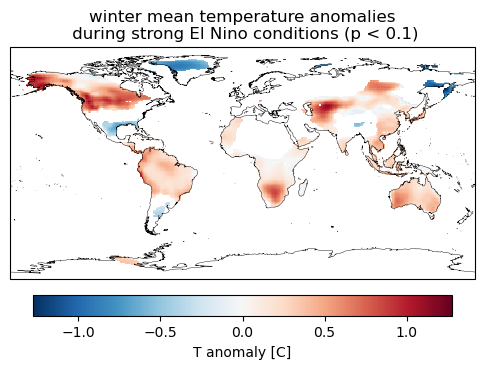

In [15]:
# copied from question 3 in enso_analysis.ipynb

# starting with el nino conditions, temperature
# get temperature anomalies only for times during strong el nino conditions
t_nino=t_anom.where(nino_events==1,drop=True)

# now separate out winter DJF months
# this is sample 1: winter months during strong el nino conditions
t_nino_DJF=t_nino.groupby(t_nino.time.dt.season)['DJF'] 

# make a composite
t_nino_DJF_composite=t_nino_DJF.mean('time',keep_attrs=True)

# create a t sample that include all winter months DJF when there are not strong el nino conditions

# all months that don't fall in strong nino events
t_other=t_anom.where(nino_events!=1,drop=True) 

# pull out just DJF months
# this is sample 2: all winter months that are NOT during strong el nino conditions
t_other_DJF=t_other.groupby(t_other.time.dt.season)['DJF'] 

print('t nino and non-nino sample sizes:',t_nino_DJF.shape[0],t_other_DJF.shape[0]) 

# t-test for difference in means 
t_sigtest = ss.ttest_ind(t_nino_DJF, t_other_DJF, axis=0, equal_var=False)
# numpy --> xarray
t_nino_pval = xr.DataArray(t_sigtest.pvalue, coords={'lat':('lat',t_nino.coords['lat'].data),'lon':('lon',t_nino.coords['lon'].data)})


# plot el nino temperature anomalies where statistically significant at 90% level
pval=0.1

fig=plt.figure(figsize=(6,4))

ax=fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
t_nino_DJF_composite.where(t_nino_pval<pval).plot(cmap='RdBu_r',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'winter mean temperature anomalies\n during strong El Nino conditions (p < {pval})')

plt.show()


Now we can use our shapefile to answer the question: which South American countries experience statistically significant anomalous temperature and precipitation over at least 50% of the country's area during strong El Nino? 

In [163]:
t_nino_DJF_composite

<xarray.DataArray 'tavg' (lat: 180, lon: 360)> Size: 259kB
array([[-0.05417551, -0.05384723, -0.05352813, ..., -0.05519971,
        -0.05485266, -0.05451055],
       [-0.01103011, -0.01011099, -0.00920994, ..., -0.01389625,
        -0.01292047, -0.01196289],
       [ 0.02968025,  0.03112871,  0.03255376, ...,  0.02517492,
         0.0267008 ,  0.02820158],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes:
    standard_name:  T anomaly
    units:          C

In [165]:
# first create a pandas dataframe from our results t_nino_DJF_composite and t_nino_pval

# convert each xarray data array object to a pandas data frame
t_nino_DJF_composite_df=t_nino_DJF_composite.to_dataframe().reset_index(level=[0,1])

t_nino_pval.name='pval'
t_nino_pval_df=t_nino_pval.to_dataframe().reset_index(level=[0,1])

# # merge pvalues into t_nino_DJF_composite_df
t_nino_DJF_composite_df=t_nino_DJF_composite_df.merge(t_nino_pval_df, how='left',on=['lat','lon'])
t_nino_DJF_composite_df

,lat,lon,tavg,pval
0,-89.5,-179.5,-0.054176,NaN
1,-89.5,-178.5,-0.053847,NaN
2,-89.5,-177.5,-0.053528,NaN
3,-89.5,-176.5,-0.053207,NaN
4,-89.5,-175.5,-0.052902,NaN
...,...,...,...,...
64795,89.5,175.5,NaN,NaN
64796,89.5,176.5,NaN,NaN
64797,89.5,177.5,NaN,NaN
64798,89.5,178.5,NaN,NaN


In [144]:
# now use the xagg package to compute the overlaps between grid cell polygons and country polygons
# pixel_overlaps computes the relative area of overlap for each grid cell polygon
# it takes an xarray dataset and a geopandas dataframe as inputs
# see https://xagg.readthedocs.io/en/latest/xagg.html#xagg.wrappers.pixel_overlaps
# and https://xagg.readthedocs.io/en/latest/xagg.html#xagg.core.get_pixel_overlaps
weightmap = xa.pixel_overlaps(t_nino_DJF_composite,countries)#,subset_bbox=False)

creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!


In [156]:
# xa.pixel_overlaps function returns an object that contains 
# 1) a pandas dataframe with the grid cell polygon overlap information, 
# 2) a dictionary containing the xarray data array source grid info, 
# 3) a pandas series of geometry objects containing the geopandas source geometry info

# access the dataframe with .agg
weightmap.agg.head()

,COUNTRY,ISO_CC,CONTINENT,LAND_TYPE,LAND_RANK,COUNTRYAFF,area_km2,poly_idx,rel_area,pix_idxs,coords
0,Argentina,ARG,South America,Primary land,5,Argentina,2.764644e+06,0,"[[3.638178503865549e-05, 0.0013290905677736432...","[116, 164, 165, 166, 167, 214, 215, 261, 262, ...","[(-55.5, -66.5), (-54.5, -68.5), (-54.5, -67.5..."
1,Bolivia,BOL,South America,Primary land,5,"Bolivia, Plurinational State of",1.080448e+09,1,"[[9.511847947184467e-06, 0.007989359460287183,...","[1764, 1765, 1766, 1767, 1768, 1769, 1770, 181...","[(-22.5, -68.5), (-22.5, -67.5), (-22.5, -66.5..."
2,Brazil,BRA,South America,Primary land,5,Brazil,8.409169e+06,2,"[[0.0003909635459040637, 0.0001430188994806563...","[1229, 1230, 1279, 1280, 1281, 1326, 1327, 132...","[(-33.5, -53.5), (-33.5, -52.5), (-32.5, -53.5..."
3,Chile,CHL,South America,Primary land,5,Chile,6.863458e+05,3,"[[1.4056450381730853e-05, 0.002994453441234760...","[112, 113, 114, 115, 160, 161, 162, 163, 164, ...","[(-55.5, -70.5), (-55.5, -69.5), (-55.5, -68.5..."
4,Colombia,COL,South America,Primary land,5,Colombia,1.130327e+06,4,"[[0.0001646554687212082, 0.0002030653860236081...","[2662, 2663, 2712, 2713, 2759, 2760, 2761, 276...","[(-4.5, -70.5), (-4.5, -69.5), (-3.5, -70.5), ..."


xagg.pixel_overlaps calculates how much relative area of a country polygon that each grid cell that intersects the country occupies. The column rel_area contains this information

In [157]:
# the relative area of each pixel intersecting the first polygon/mulipolygon (Argentina)
# would be indexed like this, which returns a pandas series of 351 values
# in this case 351 grid cells of our xarray data array intersect the Argentina polygon
weightmap.agg['rel_area'][0][0]

0      0.000036
1      0.001329
2      0.002196
3      0.001487
4      0.000563
         ...   
346    0.002459
347    0.000147
348    0.000041
349    0.000004
350    0.000002
Length: 351, dtype: float64

In [158]:
# the coordinates that correspond to the rel_area values
# would be indexed like this, which returns a list of 351 (lat,lon) tuples
weightmap.agg['coords'][0]

[(-55.5, -66.5),
 (-54.5, -68.5),
 (-54.5, -67.5),
 (-54.5, -66.5),
 (-54.5, -65.5),
 (-53.5, -68.5),
 (-53.5, -67.5),
 (-52.5, -71.5),
 (-52.5, -70.5),
 (-52.5, -69.5),
 (-52.5, -68.5),
 (-51.5, -72.5),
 (-51.5, -71.5),
 (-51.5, -70.5),
 (-51.5, -69.5),
 (-51.5, -68.5),
 (-50.5, -73.5),
 (-50.5, -72.5),
 (-50.5, -71.5),
 (-50.5, -70.5),
 (-50.5, -69.5),
 (-50.5, -68.5),
 (-50.5, -67.5),
 (-49.5, -73.5),
 (-49.5, -72.5),
 (-49.5, -71.5),
 (-49.5, -70.5),
 (-49.5, -69.5),
 (-49.5, -68.5),
 (-49.5, -67.5),
 (-48.5, -72.5),
 (-48.5, -71.5),
 (-48.5, -70.5),
 (-48.5, -69.5),
 (-48.5, -68.5),
 (-48.5, -67.5),
 (-48.5, -66.5),
 (-48.5, -65.5),
 (-47.5, -72.5),
 (-47.5, -71.5),
 (-47.5, -70.5),
 (-47.5, -69.5),
 (-47.5, -68.5),
 (-47.5, -67.5),
 (-47.5, -66.5),
 (-47.5, -65.5),
 (-46.5, -71.5),
 (-46.5, -70.5),
 (-46.5, -69.5),
 (-46.5, -68.5),
 (-46.5, -67.5),
 (-46.5, -66.5),
 (-45.5, -71.5),
 (-45.5, -70.5),
 (-45.5, -69.5),
 (-45.5, -68.5),
 (-45.5, -67.5),
 (-45.5, -66.5),
 (-45.5, -65.5

For each country we want to create a dataframe where each row contains data for a single grid cell: relative area, lat, lon values, data value, pvalue. We'll start with the first country Argentina

In [167]:
df=pd.DataFrame(weightmap.agg['coords'][0],columns=['lat','lon'])
df['rel_area']=weightmap.agg['rel_area'][0][0]
df=df.merge(t_nino_DJF_composite_df, how='left',on=['lat','lon'])
df

,lat,lon,rel_area,tavg,pval
0,-55.5,-66.5,0.000036,NaN,NaN
1,-54.5,-68.5,0.001329,-0.193445,6.655706e-01
2,-54.5,-67.5,0.002196,-0.213403,6.844212e-01
3,-54.5,-66.5,0.001487,-0.234403,6.895380e-01
4,-54.5,-65.5,0.000563,-0.257212,6.784821e-01
...,...,...,...,...,...
346,-22.5,-62.5,0.002459,0.253118,1.653059e-02
347,-21.5,-66.5,0.000147,0.447573,3.928706e-08
348,-21.5,-65.5,0.000041,0.405656,1.089635e-06
349,-21.5,-63.5,0.000004,0.276206,1.769765e-03


In [170]:
df.dtypes

lat         float64
lon         float64
rel_area    float64
tavg        float32
pval        float32
dtype: object

In [172]:
# to get the relative area of the country where nino anomalies meet the 90% confidence level
area_impacted=df.loc[df['pval']<=0.1].rel_area.sum()
area_impacted

0.3009207060012917

To get the result for all countries we can write a function and loop. 

In [179]:
def percent_area_impacted(coords,rel_area,xr_pval):
    df=pd.DataFrame(coords,columns=['lat','lon'])
    df['rel_area']=rel_area
    
    xr_pval.name='pval'
    pval_df=xr_pval.to_dataframe().reset_index(level=[0,1])
    df=df.merge(pval_df, how='left',on=['lat','lon'])

    area_impacted=df.loc[df['pval']<=0.1].rel_area.sum()*100.
    return area_impacted

In [181]:
results={}
for index,row in weightmap.agg.iterrows():
    answer=percent_area_impacted(row.coords,row.rel_area[0],t_nino_pval)
    results[row.COUNTRY]=answer
results

{'Argentina': 30.092070600129173,
 'Bolivia': 0.0,
 'Brazil': 38.89844398464537,
 'Chile': 0.0,
 'Colombia': 0.0,
 'Ecuador': 0.0,
 'French Guiana': 0.0,
 'Guyana': 0.0,
 'Paraguay': 0.0,
 'Peru': 0.0,
 'Suriname': 0.0,
 'Trinidad and Tobago': 0.0,
 'Uruguay': 0.0,
 'Venezuela': 0.0}

In [153]:
# access the dictionary with .source_grid
weightmap.source_grid

{'lat': <xarray.DataArray 'lat' (loc: 3600)> Size: 14kB
 array([-57.5, -57.5, -57.5, ...,  13.5,  13.5,  13.5], dtype=float32)
 Coordinates:
   * loc      (loc) object 29kB MultiIndex
   * lat      (loc) float32 14kB -57.5 -57.5 -57.5 -57.5 ... 13.5 13.5 13.5 13.5
   * lon      (loc) float32 14kB -82.5 -81.5 -80.5 -79.5 ... -35.5 -34.5 -33.5
 Attributes:
     units:          degrees_north
     standard_name:  latitude
     long_name:      Latitude,
 'lon': <xarray.DataArray 'lon' (loc: 3600)> Size: 14kB
 array([-82.5, -81.5, -80.5, ..., -35.5, -34.5, -33.5], dtype=float32)
 Coordinates:
   * loc      (loc) object 29kB MultiIndex
   * lat      (loc) float32 14kB -57.5 -57.5 -57.5 -57.5 ... 13.5 13.5 13.5 13.5
   * lon      (loc) float32 14kB -82.5 -81.5 -80.5 -79.5 ... -35.5 -34.5 -33.5
 Attributes:
     units:          degrees_east
     standard_name:  longitude
     long_name:      Longitude}

In [154]:
weightmap.geometry

0     MULTIPOLYGON (((-68.25998 -53.01153, -68.24424...
1     POLYGON ((-65.36548 -9.70831, -65.35947 -9.716...
2     MULTIPOLYGON (((-47.90001 -25.07994, -47.90333...
3     MULTIPOLYGON (((-69.54033 -55.43446, -69.53619...
4     MULTIPOLYGON (((-78.43286 2.51681, -78.43295 2...
5     MULTIPOLYGON (((-80.24430 -3.33325, -80.24380 ...
6     POLYGON ((-51.83801 3.85019, -51.84795 3.83910...
7     MULTIPOLYGON (((-59.32561 8.15459, -59.29367 8...
8     POLYGON ((-59.71332 -19.27806, -59.65094 -19.2...
9     POLYGON ((-74.97293 -0.15364, -74.97009 -0.166...
10    POLYGON ((-56.95217 6.01095, -56.94122 6.00815...
11    POLYGON ((-60.93093 10.83899, -60.92782 10.838...
12    POLYGON ((-57.06139 -30.08831, -57.06345 -30.0...
13    MULTIPOLYGON (((-60.36367 8.63267, -60.32767 8...
Name: geometry, dtype: geometry

In [94]:
pr_test=pr_anom.isel(time=0).to_dataset()
pr_test

<xarray.Dataset> Size: 261kB
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    time     datetime64[ns] 8B 1948-01-01
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    month    int64 8B 1
Data variables:
    precip   (lat, lon) float32 259kB -0.03222 -0.03348 -0.03522 ... nan nan nan

In [117]:
# testdf=pr_test.stack(cell=('lat','lon')).to_dataframe()#.to_pandas()#.drop_vars(['lat','lon'])
testdf=pr_test.to_dataframe().reset_index(level=[0,1])#.to_pandas()#.drop_vars(['lat','lon'])

# testdf=testdf.reindex()
testdf

,lat,lon,time,month,precip
0,-89.5,-179.5,1948-01-01,1,-0.032222
1,-89.5,-178.5,1948-01-01,1,-0.033481
2,-89.5,-177.5,1948-01-01,1,-0.035222
3,-89.5,-176.5,1948-01-01,1,-0.035741
4,-89.5,-175.5,1948-01-01,1,-0.035222
...,...,...,...,...,...
64795,89.5,175.5,1948-01-01,1,NaN
64796,89.5,176.5,1948-01-01,1,NaN
64797,89.5,177.5,1948-01-01,1,NaN
64798,89.5,178.5,1948-01-01,1,NaN


In [118]:
weightmap = xa.pixel_overlaps(pr_test,countries,subset_bbox=False)
weightmap

creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!


In [121]:
rel_area=weightmap.agg['rel_area']
rel_area

0     [[3.638178503865549e-05, 0.0013290905677736432...
1     [[9.511847947184467e-06, 0.007989359460287183,...
2     [[0.0003909635459040637, 0.0001430188994806563...
3     [[1.4056450381730853e-05, 0.002994453441234760...
4     [[0.0001646554687212082, 0.0002030653860236081...
5     [[2.039199914136036e-05, 0.008095862584611072,...
6     [[0.04188888844701473, 0.107367994386439, 0.05...
7     [[0.019887338331850656, 0.03580150923629318, 0...
8     [[0.0043918908595352085, 0.01067084818903745, ...
9     [[0.001870743865531972, 0.0003740564621722778,...
10    [[0.004236001621916575, 0.0009679934938545338,...
11          [[0.9819392295893178, 0.01806077041068229]]
12    [[0.0026820117145874, 0.02530482327627714, 0.0...
13    [[0.0014446952689888943, 0.00119407699822561, ...
Name: rel_area, dtype: object

In [122]:
coords=weightmap.agg['coords']
coords

0     [(-55.5, -66.5), (-54.5, -68.5), (-54.5, -67.5...
1     [(-22.5, -68.5), (-22.5, -67.5), (-22.5, -66.5...
2     [(-33.5, -53.5), (-33.5, -52.5), (-32.5, -53.5...
3     [(-55.5, -70.5), (-55.5, -69.5), (-55.5, -68.5...
4     [(-4.5, -70.5), (-4.5, -69.5), (-3.5, -70.5), ...
5     [(-5.5, -79.5), (-4.5, -80.5), (-4.5, -79.5), ...
6     [(2.5, -54.5), (2.5, -53.5), (2.5, -52.5), (3....
7     [(1.5, -59.5), (1.5, -58.5), (1.5, -57.5), (1....
8     [(-27.5, -58.5), (-27.5, -57.5), (-27.5, -56.5...
9     [(-18.5, -70.5), (-18.5, -69.5), (-17.5, -72.5...
10    [(1.5, -56.5), (1.5, -55.5), (2.5, -57.5), (2....
11                       [(10.5, -61.5), (10.5, -60.5)]
12    [(-34.5, -58.5), (-34.5, -57.5), (-34.5, -56.5...
13    [(0.5, -66.5), (0.5, -65.5), (1.5, -67.5), (1....
Name: coords, dtype: object

In [126]:
# the relative area of each pixel intersecting the first polygon/mulipolygon
# would be indexed like this, which returns a pandas series of 351 values
rel_area[0][0]

0      0.000036
1      0.001329
2      0.002196
3      0.001487
4      0.000563
         ...   
346    0.002459
347    0.000147
348    0.000041
349    0.000004
350    0.000002
Length: 351, dtype: float64

In [130]:
# the coordinates that correspond to the rel_area valuse/pixels
# would be indexed like this, which returns a list of 351 (lat,lon) tuples
coords[0]

[(-55.5, -66.5),
 (-54.5, -68.5),
 (-54.5, -67.5),
 (-54.5, -66.5),
 (-54.5, -65.5),
 (-53.5, -68.5),
 (-53.5, -67.5),
 (-52.5, -71.5),
 (-52.5, -70.5),
 (-52.5, -69.5),
 (-52.5, -68.5),
 (-51.5, -72.5),
 (-51.5, -71.5),
 (-51.5, -70.5),
 (-51.5, -69.5),
 (-51.5, -68.5),
 (-50.5, -73.5),
 (-50.5, -72.5),
 (-50.5, -71.5),
 (-50.5, -70.5),
 (-50.5, -69.5),
 (-50.5, -68.5),
 (-50.5, -67.5),
 (-49.5, -73.5),
 (-49.5, -72.5),
 (-49.5, -71.5),
 (-49.5, -70.5),
 (-49.5, -69.5),
 (-49.5, -68.5),
 (-49.5, -67.5),
 (-48.5, -72.5),
 (-48.5, -71.5),
 (-48.5, -70.5),
 (-48.5, -69.5),
 (-48.5, -68.5),
 (-48.5, -67.5),
 (-48.5, -66.5),
 (-48.5, -65.5),
 (-47.5, -72.5),
 (-47.5, -71.5),
 (-47.5, -70.5),
 (-47.5, -69.5),
 (-47.5, -68.5),
 (-47.5, -67.5),
 (-47.5, -66.5),
 (-47.5, -65.5),
 (-46.5, -71.5),
 (-46.5, -70.5),
 (-46.5, -69.5),
 (-46.5, -68.5),
 (-46.5, -67.5),
 (-46.5, -66.5),
 (-45.5, -71.5),
 (-45.5, -70.5),
 (-45.5, -69.5),
 (-45.5, -68.5),
 (-45.5, -67.5),
 (-45.5, -66.5),
 (-45.5, -65.5

In [138]:
# for each polygon, we can create a df of pixel rel_area, center coordinates, and data value like this
df=pd.DataFrame(coords[0],columns=['lat','lon'])
df['rel_area']=rel_area[0][0]
df=df.merge(testdf, how='left',on=['lat','lon'])
df

,lat,lon,rel_area,time,month,precip
0,-55.5,-66.5,0.000036,1948-01-01,1,-0.556367
1,-54.5,-68.5,0.001329,1948-01-01,1,-0.570234
2,-54.5,-67.5,0.002196,1948-01-01,1,-0.479866
3,-54.5,-66.5,0.001487,1948-01-01,1,-0.398433
4,-54.5,-65.5,0.000563,1948-01-01,1,-0.309200
...,...,...,...,...,...,...
346,-22.5,-62.5,0.002459,1948-01-01,1,-0.789700
347,-21.5,-66.5,0.000147,1948-01-01,1,-0.019833
348,-21.5,-65.5,0.000041,1948-01-01,1,0.478000
349,-21.5,-63.5,0.000004,1948-01-01,1,-0.147966


In [140]:
# to find the area where the data variable meets some criteria 
# for example, the magnitude of the pr anomaly gt 0.5

df_sub=df[abs(df['precip'])>=0.5]
relarea_criteria=df_sub['rel_area'].sum()
relarea_criteria

# now multiply by the area of the polygon

0.525309993524063

In [62]:
# peru=countries.loc[9]
peru=countries[countries.COUNTRY=='Peru']
# peru
weightmap2 = xa.pixel_overlaps(pr_anom_ds,peru,subset_bbox=False)
weightmap2.agg['rel_area']

creating polygons for each pixel...
calculating overlaps between pixels and output polygons...
success!


0    [[0.0018522553162452168, 0.0003713283676925149...
Name: rel_area, dtype: object

In [64]:
weightmap2.agg

,COUNTRY,ISO_CC,CONTINENT,LAND_TYPE,LAND_RANK,COUNTRYAFF,area_km2,poly_idx,rel_area,pix_idxs,coords
0,Peru,PER,South America,Primary land,5,Peru,1.289477e+09,0,"[[0.0018522553162452168, 0.0003713283676925149...","[25669, 25670, 26027, 26028, 26029, 26030, 263...","[(-18.5, -70.5), (-18.5, -69.5), (-17.5, -72.5..."


In [73]:
weightmap2.agg.rel_area[0][0]

0      0.001852
1      0.000371
2      0.000022
3      0.003897
4      0.009027
         ...   
142    0.005754
143    0.009460
144    0.004375
145    0.002852
146    0.004220
Length: 147, dtype: float64

In [74]:
sum(weightmap2.agg.rel_area[0][0])

1.0000000000000002

In [89]:
# np.array(weightmap2.agg.coords[0]).shape#.rel_area[0][0]

weightmap2.agg.coords[0]#[1][1])

[(-18.5, -70.5),
 (-18.5, -69.5),
 (-17.5, -72.5),
 (-17.5, -71.5),
 (-17.5, -70.5),
 (-17.5, -69.5),
 (-16.5, -74.5),
 (-16.5, -73.5),
 (-16.5, -72.5),
 (-16.5, -71.5),
 (-16.5, -70.5),
 (-16.5, -69.5),
 (-16.5, -68.5),
 (-15.5, -75.5),
 (-15.5, -74.5),
 (-15.5, -73.5),
 (-15.5, -72.5),
 (-15.5, -71.5),
 (-15.5, -70.5),
 (-15.5, -69.5),
 (-14.5, -76.5),
 (-14.5, -75.5),
 (-14.5, -74.5),
 (-14.5, -73.5),
 (-14.5, -72.5),
 (-14.5, -71.5),
 (-14.5, -70.5),
 (-14.5, -69.5),
 (-14.5, -68.5),
 (-13.5, -76.5),
 (-13.5, -75.5),
 (-13.5, -74.5),
 (-13.5, -73.5),
 (-13.5, -72.5),
 (-13.5, -71.5),
 (-13.5, -70.5),
 (-13.5, -69.5),
 (-13.5, -68.5),
 (-12.5, -77.5),
 (-12.5, -76.5),
 (-12.5, -75.5),
 (-12.5, -74.5),
 (-12.5, -73.5),
 (-12.5, -72.5),
 (-12.5, -71.5),
 (-12.5, -70.5),
 (-12.5, -69.5),
 (-12.5, -68.5),
 (-11.5, -77.5),
 (-11.5, -76.5),
 (-11.5, -75.5),
 (-11.5, -74.5),
 (-11.5, -73.5),
 (-11.5, -72.5),
 (-11.5, -71.5),
 (-11.5, -70.5),
 (-11.5, -69.5),
 (-11.5, -68.5),
 (-10.5, -78.5

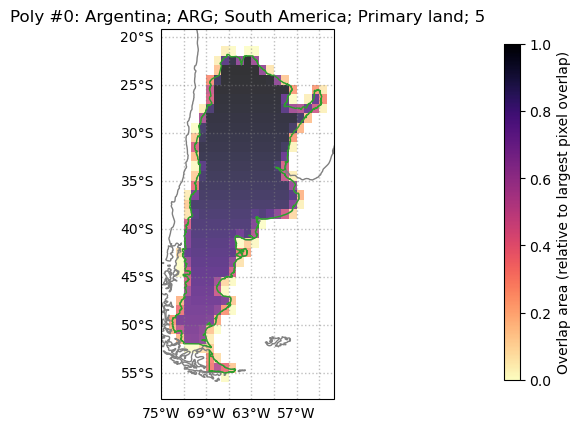

In [24]:
# # Querying polygon by column of the polygon `gdf`
# weightmap.diag_fig({'name':'Alaska'},ds)

# Plotting the first polygon in the polygon `gdf`
weightmap.diag_fig(0,pr_anom_ds)

In [50]:
import rioxarray as rio
pr_anom_ds=pr_anom.to_dataset()
# pr_anom_ds=pr_anom_ds.rename({'lat':'y','lon':'x'})
# pr_anom_ds=pr_anom_ds.rio.write_crs('epsg:4326')
# pr_test=pr_anom_ds.rio.reproject('epsg:3857')
pr_test=pr_anom_ds
pr_test

<xarray.Dataset> Size: 236MB
Dimensions:  (lat: 180, time: 912, lon: 360)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2023-12-01
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    month    (time) int64 7kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip   (time, lat, lon) float32 236MB -0.03222 -0.03348 ... nan nan

In [51]:
# pr_test=pr_test.rename({'y':'lat','x':'lon'})
pr_test=xa.auxfuncs.get_bnds(pr_test)
pr_test

lat/lon bounds not found in dataset; they will be created.


<xarray.Dataset> Size: 236MB
Dimensions:   (lat: 180, time: 912, lon: 360, bnds: 2)
Coordinates:
  * lat       (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time      (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2023-12-01
  * lon       (lon) float32 1kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    month     (time) int64 7kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: bnds
Data variables:
    precip    (time, lat, lon) float32 236MB -0.03222 -0.03348 ... nan nan
    lat_bnds  (lat, bnds) float32 1kB -90.0 -89.0 -89.0 -88.0 ... 89.0 89.0 90.0
    lon_bnds  (lon, bnds) float32 3kB -180.0 -179.0 -179.0 ... 179.0 179.0 180.0

In [53]:
grid_poly=xa.core.create_raster_polygons(pr_test)
# grid_poly,grid_dict=xa.core.create_raster_polygons(pr_test) # doesn't work this way

gdf_pixels=grid_poly['gdf_pixels']
gdf_pixels

,lat,lon,geometry,pix_idx
0,-89.5,-179.5,"POLYGON ((-180.00000 -90.00000, -180.00000 -89...",0
1,-89.5,-178.5,"POLYGON ((-179.00000 -90.00000, -179.00000 -89...",1
2,-89.5,-177.5,"POLYGON ((-178.00000 -90.00000, -178.00000 -89...",2
3,-89.5,-176.5,"POLYGON ((-177.00000 -90.00000, -177.00000 -89...",3
4,-89.5,-175.5,"POLYGON ((-176.00000 -90.00000, -176.00000 -89...",4
...,...,...,...,...
64795,89.5,175.5,"POLYGON ((175.00000 89.00000, 175.00000 90.000...",64795
64796,89.5,176.5,"POLYGON ((176.00000 89.00000, 176.00000 90.000...",64796
64797,89.5,177.5,"POLYGON ((177.00000 89.00000, 177.00000 90.000...",64797
64798,89.5,178.5,"POLYGON ((178.00000 89.00000, 178.00000 90.000...",64798


In [54]:
gdf_pixels.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
weights = np.cos(np.deg2rad(pr_anom.lat))
weights.name = "weights"
# weights

In [ ]:
pr_weighted = pr_anom.weighted(weights)
pr_weighted

In [ ]:
# cdo gridarea yourdata.nc gridarea.nc 
ds=xr.open_dataset(pr_f)
ds